source: https://ramhiser.com/post/2018-04-16-building-scikit-learn-pipeline-with-pandas-dataframe/

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import make_pipeline, FeatureUnion, Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.svm import SVC

import numpy as np
import pandas as pd

import pmlb

import random

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re

In [2]:
from sklearn.impute import SimpleImputer 

In [22]:
df = pmlb.fetch_data('churn', return_X_y=False)
df.dropna
# Remove the target column and the phone number
x_cols = [c for c in df if c not in ["target", "phone number"]]

binary_features = ["international plan", "voice mail plan"]
categorical_features = ["state", "area code"]

# Column types are defaulted to floats
X = (
    df
    .drop(["target"], axis=1)
    .astype(float)
)
X[binary_features] = X[binary_features].astype("bool")

# Categorical features can't be set all at once
for f in categorical_features:
    X[f] = X[f].astype("category")

y = df.target

# Randomly set 500 items as missing values
random.seed(42)
num_missing = 500
indices = [(row, col) for row in range(X.shape[0]) for col in range(X.shape[1])]
for row, col in random.sample(indices, num_missing):
    X.iat[row, col] = np.nan

# Partition data set into training/test split (2 to 1 ratio)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3., random_state=42)

In [23]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3333 entries, 898 to 860
Data columns (total 20 columns):
state                            3318 non-null category
account length                   3317 non-null float64
area code                        3313 non-null category
phone number                     3322 non-null float64
international plan               3333 non-null bool
voice mail plan                  3333 non-null bool
number vmail messages            3322 non-null float64
total day minutes                3323 non-null float64
total day calls                  3318 non-null float64
total day charge                 3314 non-null float64
total eve minutes                3320 non-null float64
total eve calls                  3315 non-null float64
total eve charge                 3313 non-null float64
total night minutes              3308 non-null float64
total night calls                3318 non-null float64
total night charge               3320 non-null float64
total intl minut

In [24]:
df.state.describe()

count    5000.00000
mean       25.99840
std        14.80348
min         0.00000
25%        13.00000
50%        26.00000
75%        39.00000
max        50.00000
Name: state, dtype: float64

In [25]:
df.head()
#df.info()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,number customer service calls,target
0,16,128.0,415.0,2845,0,1,25.0,265.1,110.0,45.07,...,99.0,16.78,244.7,91.0,11.01,10.0,3.0,2.70,1.0,0
1,35,107.0,415.0,2301,0,1,26.0,161.6,123.0,27.47,...,103.0,16.62,254.4,103.0,11.45,13.7,3.0,3.70,1.0,0
2,31,137.0,415.0,1616,0,0,0.0,243.4,114.0,41.38,...,110.0,10.30,162.6,104.0,7.32,12.2,5.0,3.29,0.0,0
3,35,84.0,408.0,2510,1,0,0.0,299.4,71.0,50.90,...,88.0,5.26,196.9,89.0,8.86,6.6,7.0,1.78,2.0,0
4,36,75.0,415.0,155,1,0,0.0,166.7,113.0,28.34,...,122.0,12.61,186.9,121.0,8.41,10.1,3.0,2.73,3.0,0


# Selectors
die Möglichkeit aus den gegeben df entweder Spalten nach Namen, oder nach Typ abzugreifen

## Column-Selector

In [26]:
from sklearn.pipeline import Pipeline
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)

        try:
            return X[self.columns]
        except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            raise KeyError("The DataFrame does not include the columns: %s" % cols_error)

In [27]:
cs = ColumnSelector(columns=["state", "account length", "area code"])
cs.fit_transform(df).head()

,state,account length,area code
0,16,128.0,415.0
1,35,107.0,415.0
2,31,137.0,415.0
3,35,84.0,408.0
4,36,75.0,415.0


## Type-Selector

In [28]:
class TypeSelector(BaseEstimator, TransformerMixin):
    def __init__(self, dtype):
        self.dtype = dtype

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X.select_dtypes(include=[self.dtype])

In [29]:
ts = TypeSelector("category")
ts.fit_transform(X).head()

,state,area code
0,16.0,415.0
1,35.0,415.0
2,31.0,415.0
3,35.0,408.0
4,36.0,415.0


In [30]:
df.state.isna().any()

False

# Pipeline

In [45]:
# im vgl zu Orginal ist hier der Boolean aus dem Berreich der Feature-Union raus & Der simpleimputer anstelle des Imputers rein
# austausch imputer, da ich mit einer andern version arbeite als das Tutorial
preprocess_pipeline = make_pipeline(
    ColumnSelector(columns=x_cols),
    FeatureUnion(transformer_list=[
        ("numeric_features", make_pipeline(
            TypeSelector(np.number),
            SimpleImputer(missing_values="NaN", strategy="median"),
            StandardScaler()
        )),
        ("categorical_features", make_pipeline(
            TypeSelector("category"),
            SimpleImputer(missing_values="NaN", strategy="most_frequent"),
            OneHotEncoder()
        )),

    ])
)

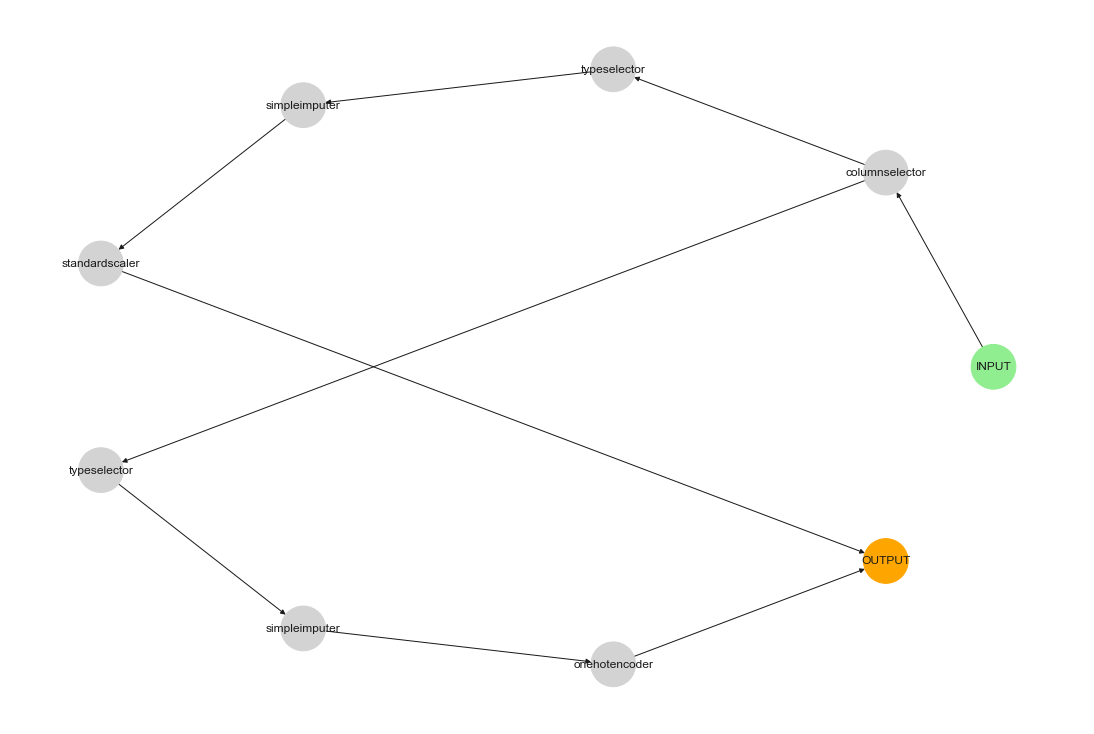

In [46]:
# das hier habe ich ergänzt. dafür dass die Grafik funktioniert brauche ich 
from pipe_tools.pipe_visualizer import plot_pipeline
plot_pipeline(preprocess_pipeline, "pipeline_plot.png")

In [47]:
x_test.
print(X_test.info())

SyntaxError: invalid syntax (<ipython-input-47-bd9f69aff6e0>, line 1)

In [48]:
preprocess_pipeline.fit(X_train)
X_test_transformed = preprocess_pipeline.transform(X_test)
X_test_transformed

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').